# Optimizing holograms using Odak

This engineering note will give you an idea about how to optimize phase-only holograms using Odak.
We consult the beginners in this matter to `Goodman's Introduction to Fourier Optics` (ISBN-13:  978-0974707723) and `Principles of optics: electromagnetic theory of propagation, interference and diffraction of light` from Max Born and Emil Wolf (ISBN 0-08-26482-4).
Note that the creators of this documentation are from the `Computational Displays` domain.
However, the provided submodules can potentially aid other lines of research as well, such as `Computational Imaging` or `Computational Microscopy`.

The optimization that is referred to in this document is the one that generates a phase-only hologram that can reconstruct a target image.
There are multiple ways in the literature to optimize a phase-only hologram for a single plane, and these include:

Gerchberg-Saxton and Yang-Yu algorithms:
- Yang, G. Z., Dong, B. Z., Gu, B. Y., Zhuang, J. Y., & Ersoy, O. K. (1994). Gerchberg–Saxton and Yang–Gu algorithms for phase retrieval in a nonunitary transform system: a comparison. Applied optics, 33(2), 209-218.

Stochastic Gradient Descent based optimization:
- Chen, Y., Chi, Y., Fan, J., & Ma, C. (2019). Gradient descent with random initialization: Fast global convergence for nonconvex phase retrieval. Mathematical Programming, 176(1), 5-37.

Odak provides functions to optimize phase-only holograms using `Gerchberg-Saxton` algorithm or the `Stochastic Gradient Descent` based approach.
The relevant functions here are `odak.learn.wave.stochastic_gradient_descent` and `odak.learn.wave.gerchberg_saxton`.
We will review both of these definitions in this document.
But first, let's get prepared.

## Preparation
We first start with imports, here is all you need:

In [1]:
from odak.learn.wave import stochastic_gradient_descent, calculate_amplitude, calculate_phase
import torch

Let's also choose which device to use for our calculation,`cpu` or `cuda`:

In [2]:
device = torch.device("cuda")

We will also be needing some variables that defines the wavelength of light that we work with:

In [3]:
wavelength = 532e-9

Pixel pitch and resolution of the phase-only hologram or a phase-only spatial light modulator that we are simulating:

In [4]:
dx = 0.0000064
resolution = [1080, 1920]

Define the distance that the light will travel from optimized hologram.

In [5]:
distance = 0.15

We have to set a target image. 
You can either load a sample image here or paint a white rectangle on a white background like in this example.

In [6]:
x = torch.linspace(-3.14, 3.14, resolution[0])
y = torch.linspace(-3.14, 3.14, resolution[1])
X, Y = torch.meshgrid(x, y)
target = torch.cos(4* (X**2 + Y**2) )
target = target + torch.abs(target.min())
target = target / target.max()

Let's visualize the target to see what we have compiled so far:

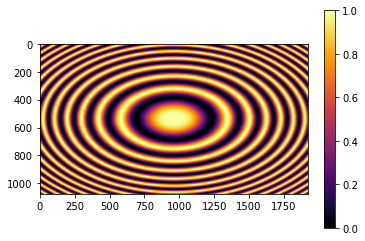

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(target.cpu(), cmap=cm.inferno)
plt.colorbar()
plt.show()

Surely, we also have to set the number of iterations and learning rate for our optimizations.
If you want the GPU support, you also have to set the `cuda` as `True`.
Propagation type has to be defined as well.
In this example, we will use transfer function Fresnel approach.
For more on propagation types, curious readers can consult 
`Computational Fourier` Optics `David Vuelz` (ISBN13:9780819482044).

In [8]:
iteration_number = 100
learning_rate = 0.1
cuda = True
propagation_type = 'TR Fresnel'

This step concludes our preparations.
Let's dive into optimizing our phase-only holograms.
Depending on your choice, you can either optimize using `Gerchberg-Saxton` approach or the `Stochastic Gradient Descent` approach.
This document will only show you `Stochastic Gradient Descent` approach as it is the state of art.
However, optimizing a phase-only hologram is as importing:

In [9]:
from odak.learn.wave import gerchberg_saxton

and almost as easy as replacing `stochastic_gradient_descent` with `gerchberg_saxton` in the upcoming described hologram routine.
For greater details, consult to [documentation of odak.learn.wave.gerchberg_saxton](https://kunguz.github.io/odak/odak/learn/wave/gerchberg_saxton/).

## Stochastic Gradient Descent approach

We have prepared a function for you to avoid compiling a differentiable hologram optimizer from scratch.

In [10]:
hologram, reconstructed = stochastic_gradient_descent(
        target,
        wavelength,
        distance,
        dx,
        resolution,
        propagation_type,
        iteration_number,
        learning_rate=learning_rate,
        cuda=cuda
    )

Iteration: 99 loss:0.0008


Congratulations! You have just optimized a phase-only hologram that reconstruct your target image at the target depth.

Let's visualize our phase-only hologram:

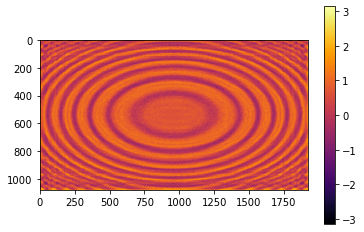

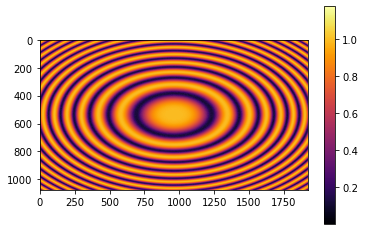

In [18]:
import matplotlib.pyplot as plt

plt.imshow(calculate_phase(hologram).cpu(), cmap=cm.inferno)
plt.colorbar()
plt.show()

plt.imshow(calculate_amplitude(reconstructed).cpu(), cmap=cm.inferno)
plt.colorbar()
plt.show()

Surely, you want to see what kind of image is being reconstructed with this newly optimized hologram.
You can save the outcome to an image file easily.
Odak provides tools to save and load images.
First, you have to import:

In [12]:
from odak.learn.tools import save_image,load_image

As you can recall, we have created a target image earlier that is normalized between zero and one. 
The same is true for our result, `reconstructed`.
Therefore, we have to save it correctly by taking that into account.
Note that `reconstructed` is the complex field generated by our optimized `hologram` variable.
So, we need to save the `reconstructed` intensity as humans and cameras capture intensity but not a complex field with phase and amplitude.

In [13]:
reconstructed_intensity = calculate_amplitude(reconstructed)**2
save_image('reconstructed_image.png',reconstructed_intensity,cmin=0.,cmax=1.)

True

To save our hologram as an image so that we can load it to a spatial light modulator, we have to normalize it between zero and 255 (dynamic range of a typical image on a computer).

P.S. Depending on your SLM's calibration and dynamic range things may vary.


In [14]:
slm_range = 2*3.14
dynamic_range = 255
phase_hologram = calculate_phase(hologram)
phase_only_hologram = (phase_hologram%slm_range)/(slm_range)*dynamic_range

It is now time for saving our hologram:

In [15]:
save_image('phase_only_hologram.png',phase_only_hologram)

True

In some cases, you may want to add a grating term to your hologram as you will display it on a spatial light modulator.
There are various reasons for that, but the most obvious is getting rid of zeroth-order reflections that are not modulated by your hologram.
In case you need it is as simple as below:

In [16]:
from odak.learn.wave import linear_grating
grating = linear_grating(resolution[0],resolution[1],axis='y').to(phase_hologram.device)
phase_only_hologram_w_grating = phase_hologram+calculate_phase(grating)

And let's save what we got from this step:

In [17]:
phase_only_hologram_w_grating = (phase_only_hologram_w_grating%slm_range)/(slm_range)*dynamic_range
save_image('phase_only_hologram_w_grating.png',phase_only_hologram_w_grating)

True